<a href="https://colab.research.google.com/github/stonelly/RentalPrediction/blob/main/WQD7001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Read the data.csv file
df = pd.read_csv('data_dirty.csv')

# Identify missing values
missing_values = df.isnull().sum()

# Describe the data
describe = df.describe().transpose()


In [3]:
missing_values


ads_id                      0
prop_name                 948
completion_year          9185
monthly_rent                2
location                    0
property_type               0
rooms                       6
parking                  5702
bathroom                    6
size                        0
furnished                   5
facilities               2209
additional_facilities    5948
region                      0
dtype: int64

In [4]:
#Format rental price to figures only
df['monthly_rent'] = df['monthly_rent'].str.replace('RM ', '').str.replace(' per month', '').str.replace(' ','')
df['monthly_rent'] = df['monthly_rent'].astype(float)

#format location to include only areas
df['location'] = df['location'].str.split('- ').str[-1]

# Remove sq.ft. from size
df['size'] = df['size'].str.replace(' sq.ft.', '')
df.loc[:, 'size'] = df['size'].astype(int)

# Assign "0" for not furnished, "1" for half furnished, "2" for fully furnished
df.loc[df["furnished"] == "Not Furnished", "furnished"] = 0
df.loc[df["furnished"] == "Partially Furnished", "furnished"] = 1
df.loc[df["furnished"] == "Fully Furnished", "furnished"] = 2

In [5]:
# Fill missing values in facilities and additional_facilities columns with empty lists
df['facilities'] = df['facilities'].fillna('')
df['additional_facilities'] = df['additional_facilities'].fillna('')

# Split facilities and additional facilities into sub-facilities
df['facilities'] = df['facilities'].str.split(', ')
df['additional_facilities'] = df['additional_facilities'].str.split(', ')

# Combine all sub-facilities into a set to get unique values
sub_facilities = set(df['facilities'].sum() + df['additional_facilities'].sum())

# Create new columns for each sub-facility and assign values based on presence
for facility in sub_facilities:
    df[facility.strip()] = df.apply(lambda row: 1 if facility in row['facilities'] or facility in row['additional_facilities'] else 0, axis=1)

# Replace the value of 'parking' with 1 if 'Parking' in the record is 1
# Fill in null value with "0" for parking
df['parking'] = df['parking'].fillna(0)
mask = (df['parking'] == 0) & (df['Parking'] == 1)
df.loc[mask, 'parking'] = 1

#  Drop unused column
df.drop(columns=["","10","6","11","facilities","additional_facilities","Parking","ads_id","prop_name","completion_year"], inplace=True)


In [6]:
# Drop outlier categories with 1 occurance in 'property type'
values_property_type = df['property_type'].value_counts()
property_type_outliers = values_property_type[values_property_type == 1].index.tolist()
for type in property_type_outliers:
    index_outlier_pt = df[df['property_type'] == type].index
    df.drop(index_outlier_pt , inplace=True)

# Drop row for category "More than 10" in rooms
index_outlier_rooms = df[df['rooms'] == 'More than 10'].index
df.drop(index_outlier_rooms , inplace=True)

# Null values
# Drop rows with null value for monthly rent, bathroom, rooms, furnished
columns_to_check = ['monthly_rent', 'bathroom', 'rooms', 'furnished']
df = df.dropna(subset=columns_to_check)

In [7]:
# Check null
missing_values = df.isnull().sum()
print(missing_values)

monthly_rent         0
location             0
property_type        0
rooms                0
parking              0
bathroom             0
size                 0
furnished            0
region               0
Lift                 0
Playground           0
Internet             0
Near KTM/LRT         0
Cooking Allowed      0
Gymnasium            0
Multipurpose hall    0
Minimart             0
Sauna                0
Jogging Track        0
Club house           0
Washing Machine      0
Air-Cond             0
Tennis Court         0
Barbeque area        0
Squash Court         0
Swimming Pool        0
Security             0
dtype: int64


In [8]:
#remove the outliers according to the monthly_rent
# Calculate the first quartile (Q1)
Q1 = df['monthly_rent'].quantile(0.25)
# Calculate the third quartile (Q3)
Q3 = df['monthly_rent'].quantile(0.75)
# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the dataset
df = df[(df['monthly_rent'] >= lower_bound) & (df['monthly_rent'] <= upper_bound)]


In [9]:
#remove the outliers according to the size
# Calculate the first quartile (Q1)
Q1 = df['size'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df['size'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the dataset
clean_df = df[(df['size'] >= lower_bound) & (df['size'] <= upper_bound)]

###Location Binning

In [10]:
# Calculate the mean monthly_rent for each location
mean_rent_by_location = clean_df.groupby('location')['monthly_rent'].mean()

# Determine bin edges based on mean monthly_rent
bin_edges = pd.qcut(mean_rent_by_location, q=6, labels=False, duplicates='drop', retbins=True)[1]

# Bin the locations into 6 bins based on mean monthly_rent
location_bins = pd.cut(mean_rent_by_location, bins=bin_edges, labels=range(1, 7))

# Assign the bins to each location in the original DataFrame
clean_df['location_bin'] = clean_df['location'].map(location_bins)

# Print the first few rows to verify the result
print(clean_df[['location', 'location_bin']])

# List of values to be removed from the location column (Beranang is outside the bin)
values_to_remove = ['360', '369', '389', '517', '639','Beranang']

# Filter out rows where the location is in the list of values to remove
clean_df = clean_df[~clean_df['location'].isin(values_to_remove)]

                   location location_bin
1                    Cheras            3
2                Taman Desa            4
3                    Sentul            4
4                Mont Kiara            6
5                   Setapak            4
...                     ...          ...
19986                Kajang            2
19987  Bandar Saujana Putra            3
19988                Kajang            2
19989             Cyberjaya            3
19990             Cyberjaya            3

[18044 rows x 2 columns]


C:\Users\chongkah\AppData\Local\Temp\ipykernel_9772\632997588.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['location_bin'] = clean_df['location'].map(location_bins)


In [11]:
#  Save the df as data.csv

clean_df.to_csv('data.csv', index=False)

<H1>EDA

##Univariate Analysis

##   Histograms

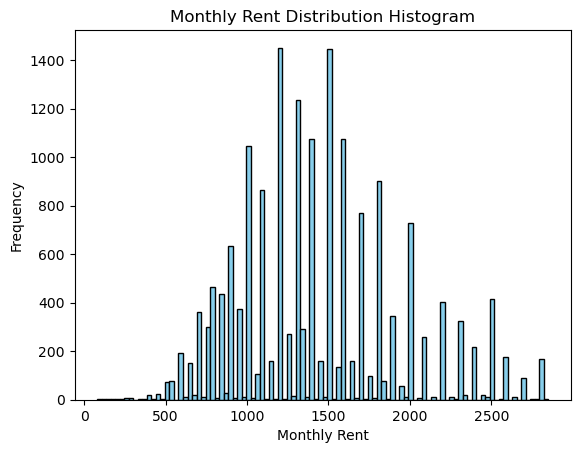

In [12]:
# Monthly Rent
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the dataset
data = pd.read_csv("data.csv")

# Create a histogram with 100 bins, sky blue color, and black edges
plt.hist(data["monthly_rent"], bins=100, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Monthly Rent')
plt.ylabel('Frequency')
plt.title('Monthly Rent Distribution Histogram')

# Display the plot
plt.show()

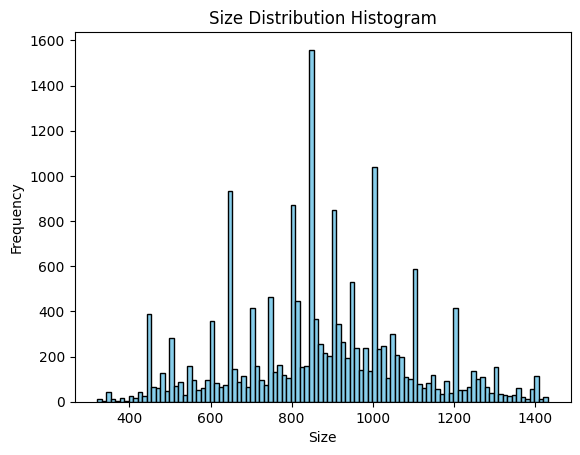

In [ ]:
# Size
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the dataset
data = pd.read_csv("data.csv")

# Create a histogram with 100 bins, sky blue color, and black edges
plt.hist(data["size"], bins=100, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Size Distribution Histogram')

# Display the plot
plt.show()

## Bar Charts

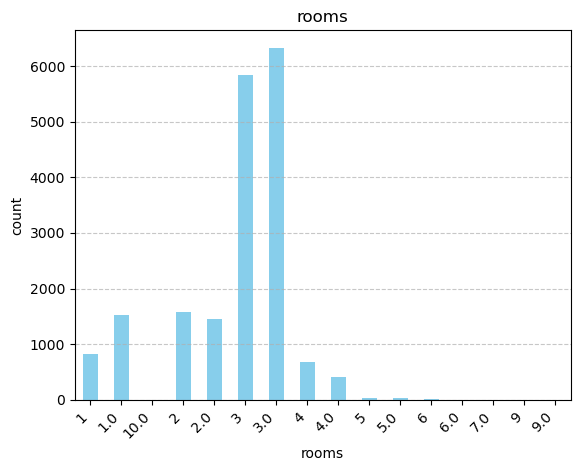

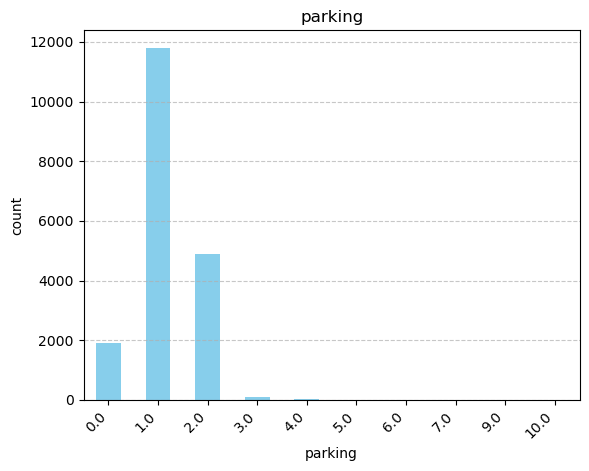

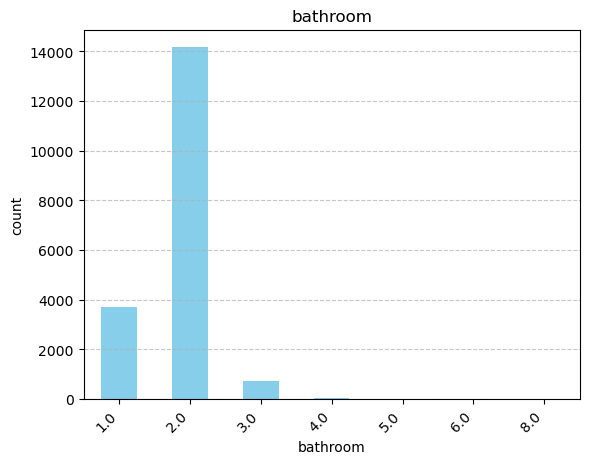

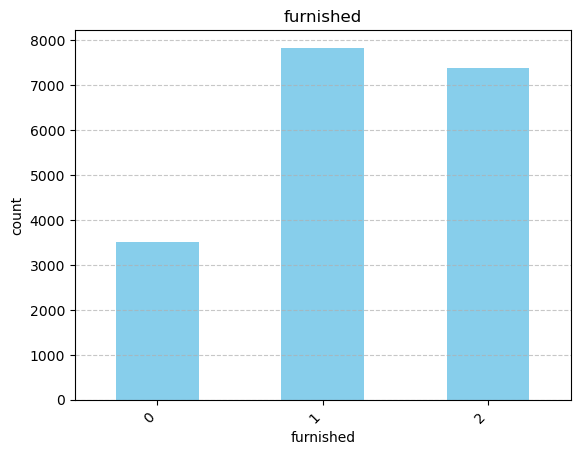

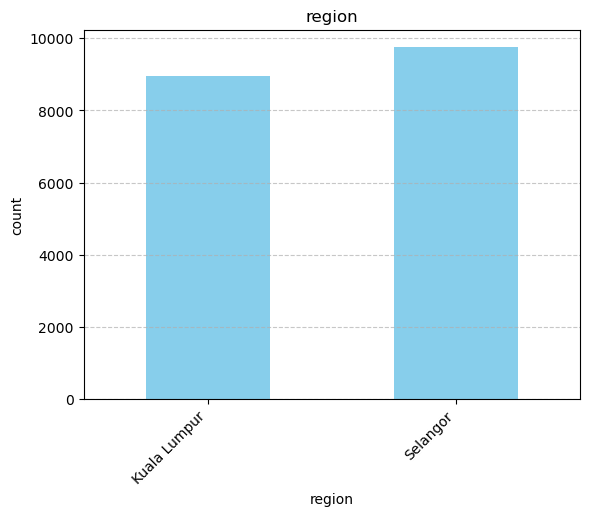

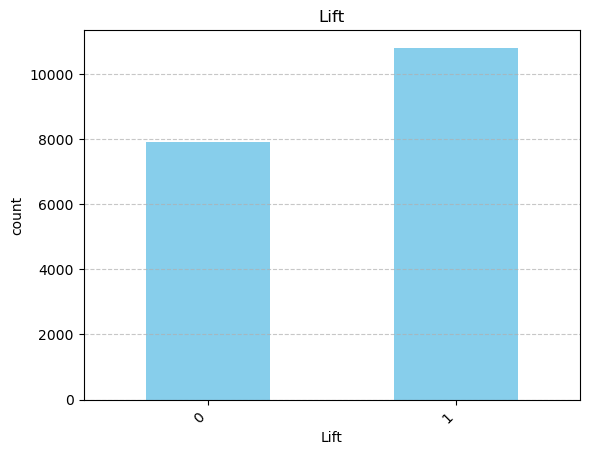

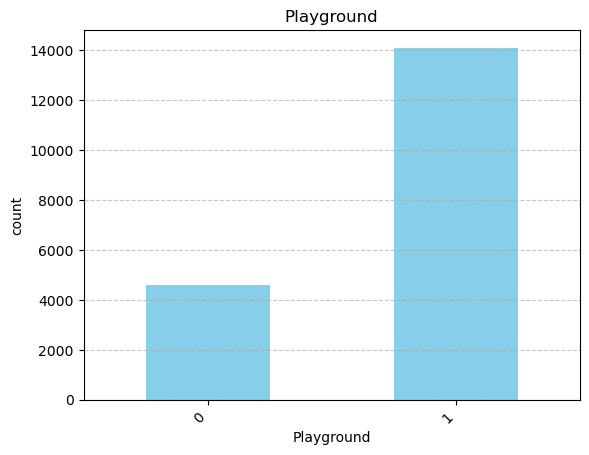

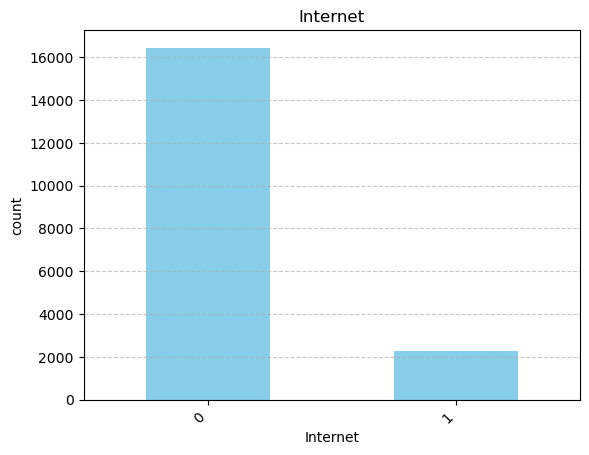

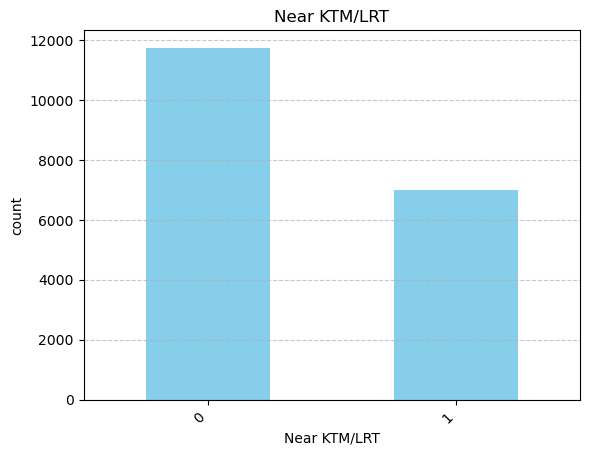

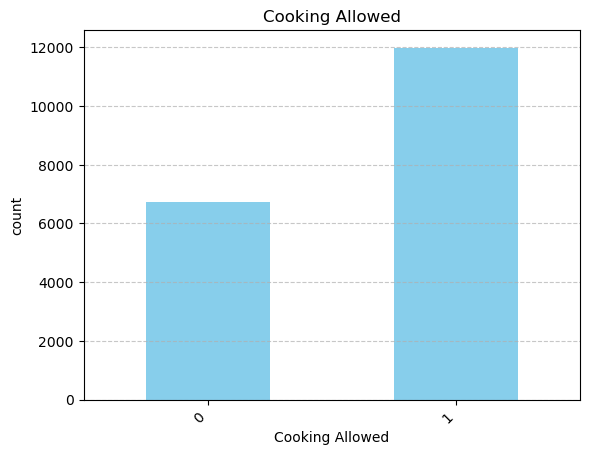

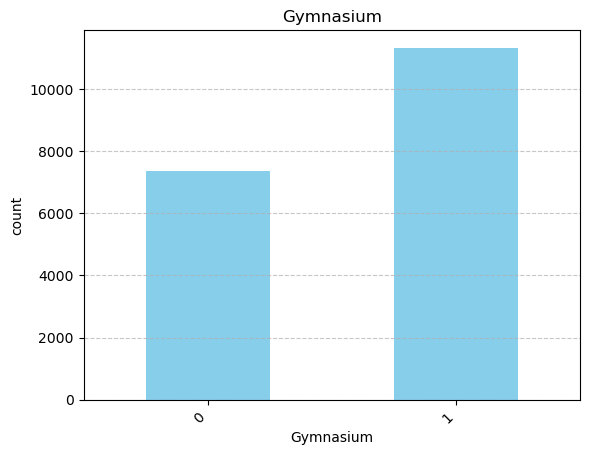

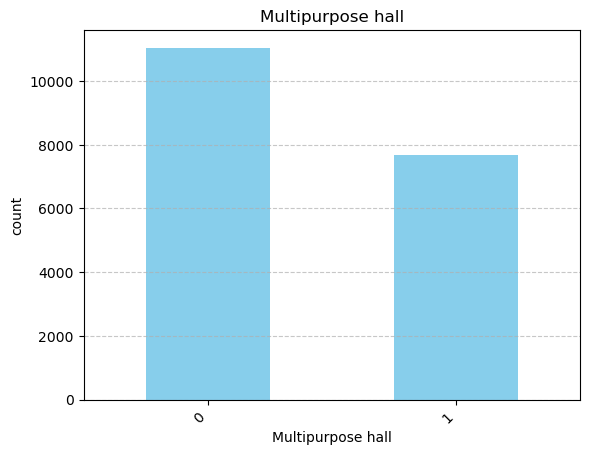

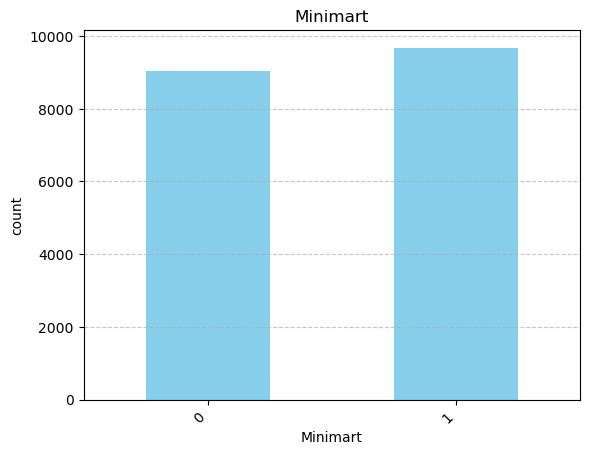

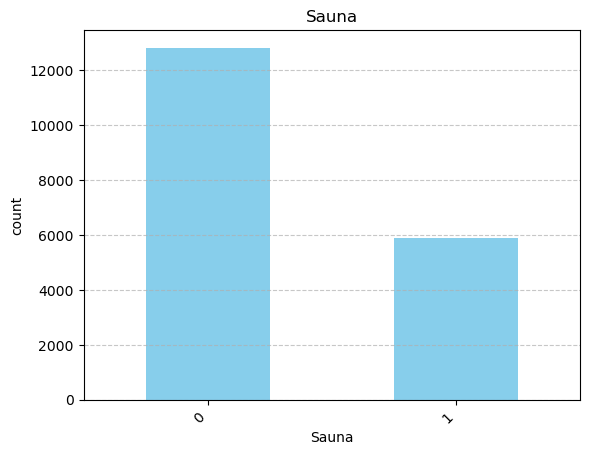

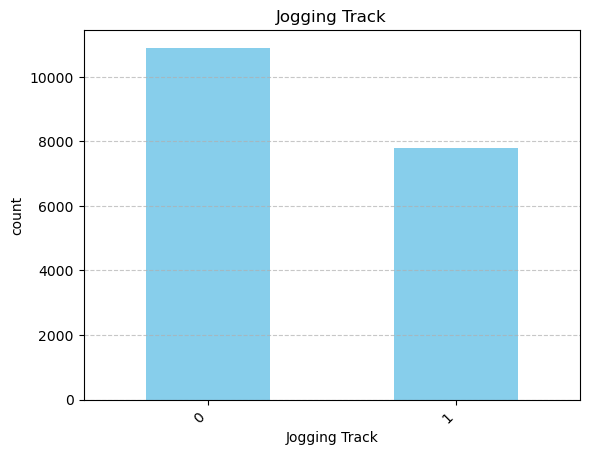

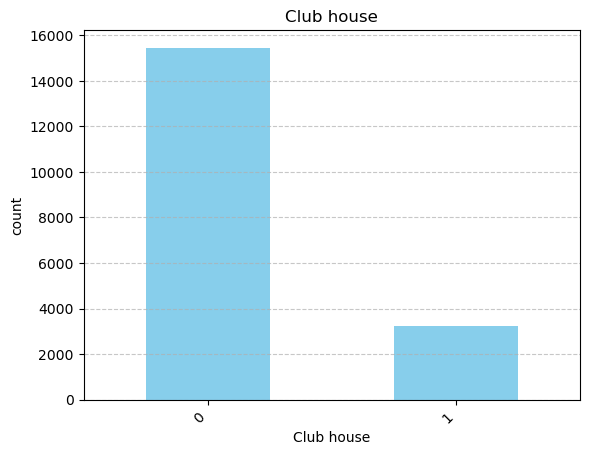

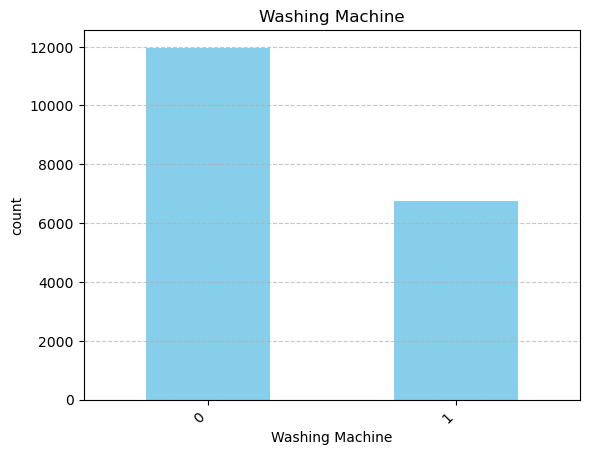

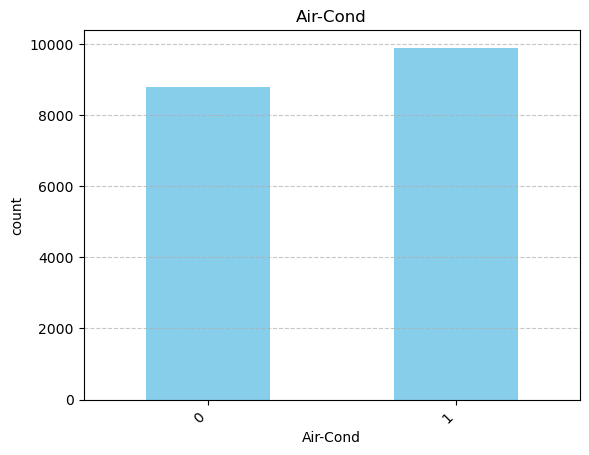

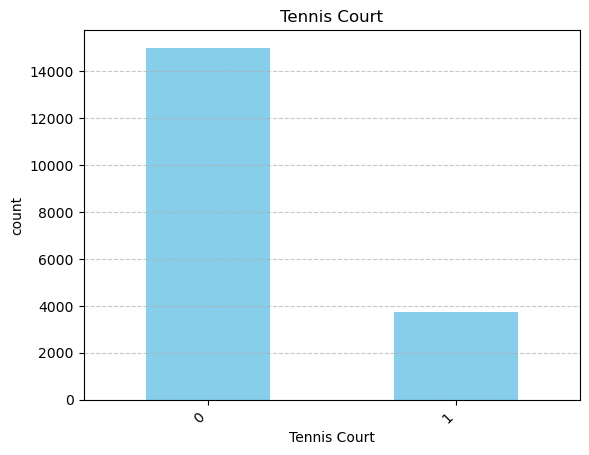

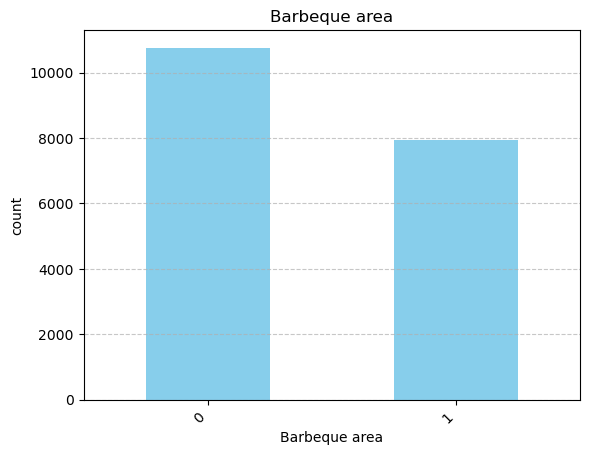

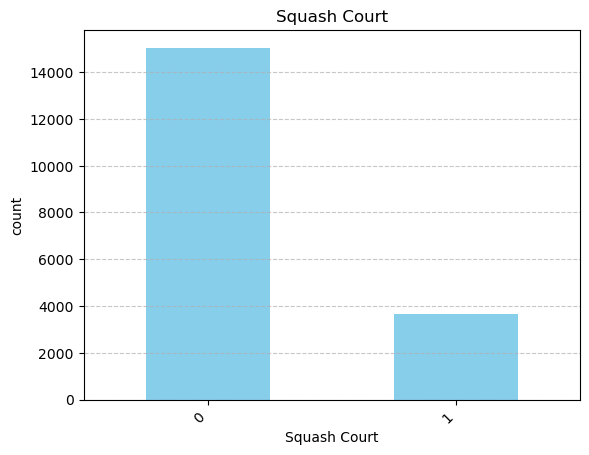

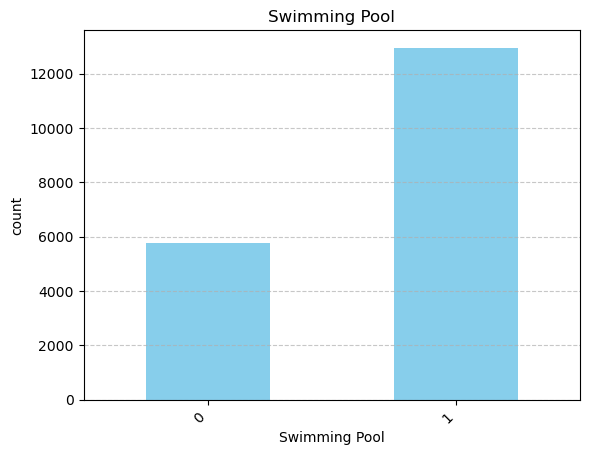

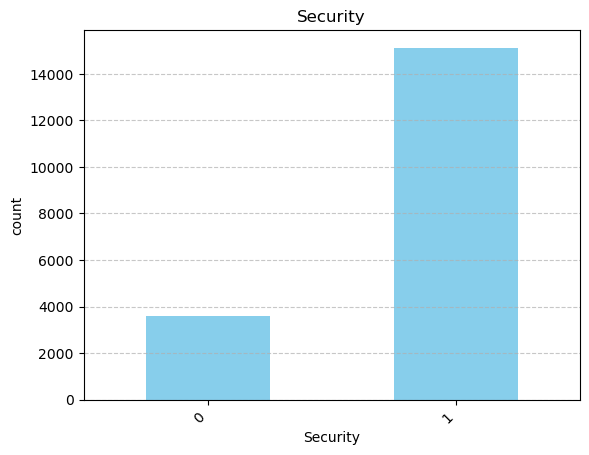

In [13]:
# Bar Charts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the dataset
data = pd.read_csv("data.csv")

# Drop location, rent, size, property type
df_bar = df.drop(columns=["location", "monthly_rent", "size", "property_type"])

# Plot bar chart for each column
for col in df_bar:
    df_bar[col].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count', color="skyblue")
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

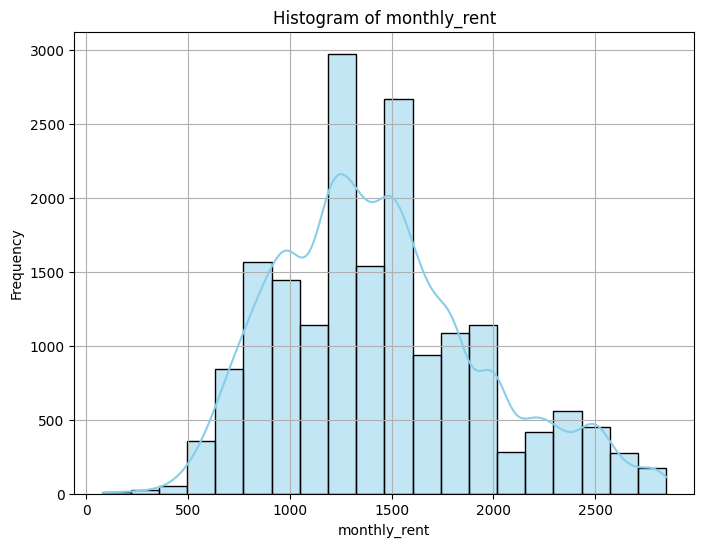

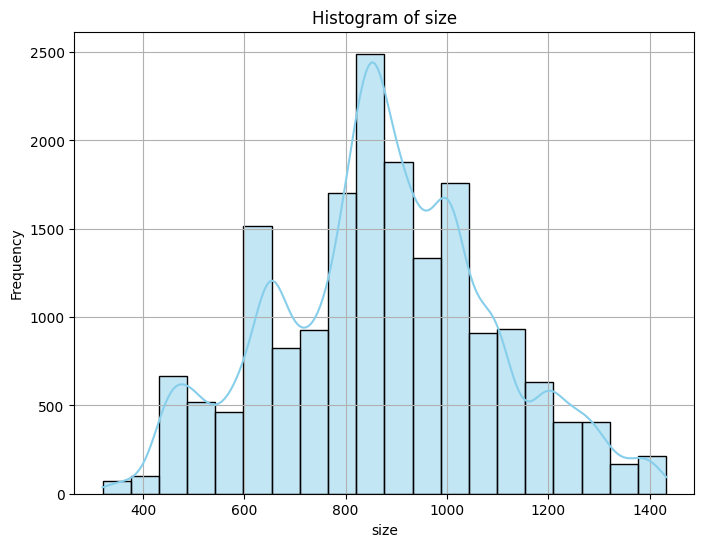

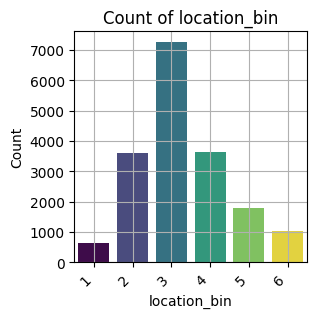

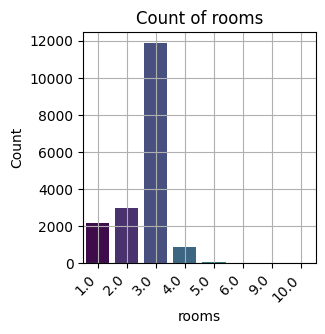

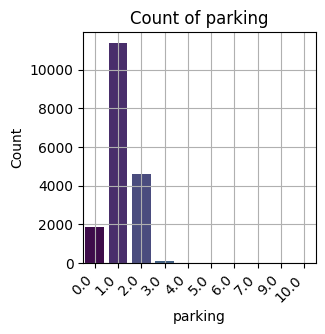

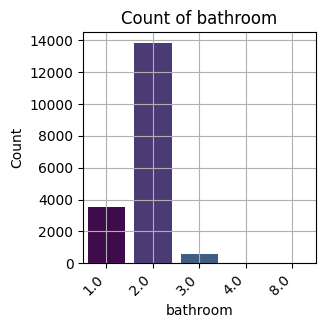

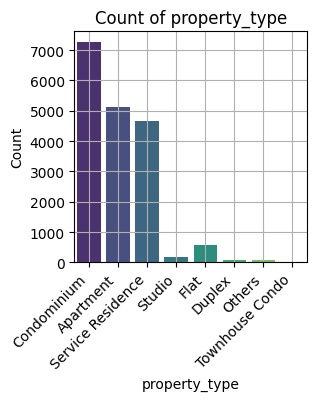

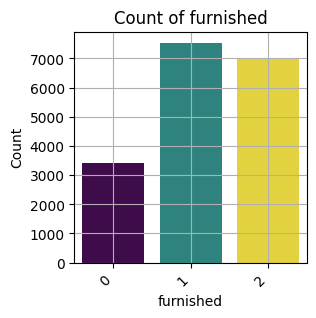

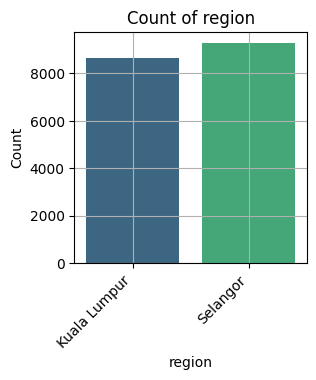

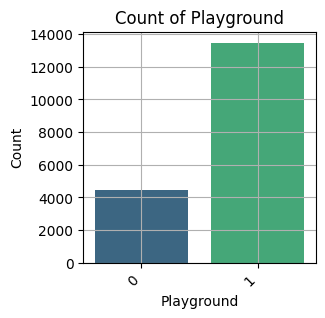

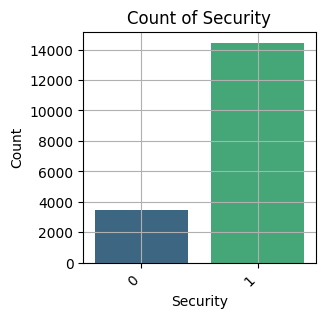

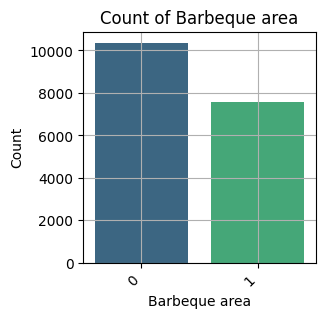

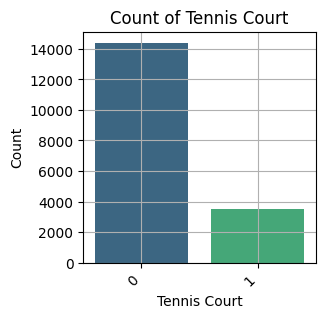

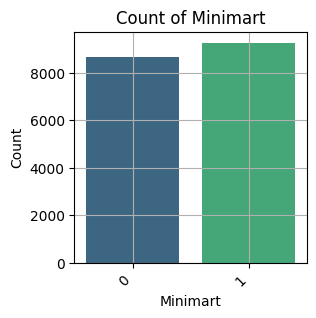

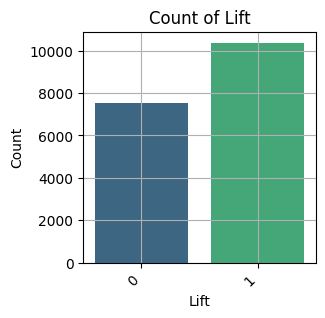

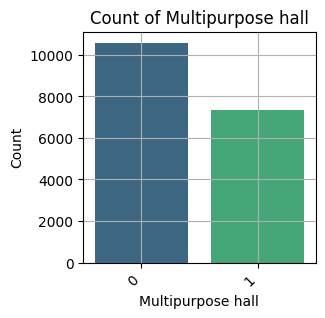

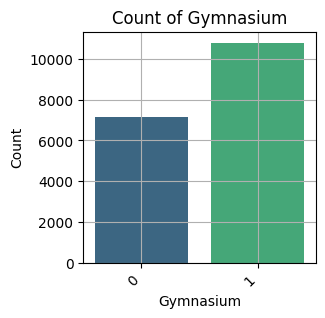

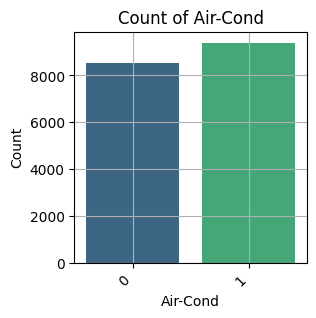

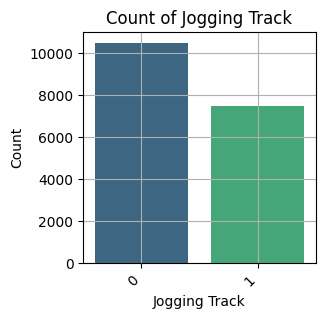

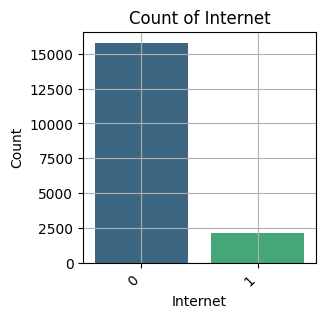

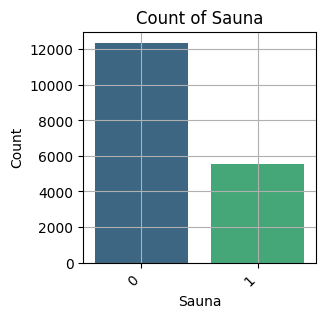

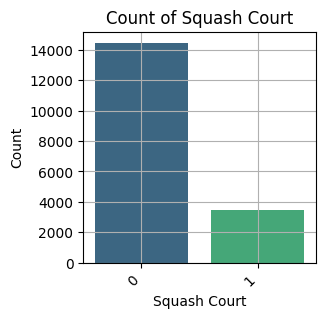

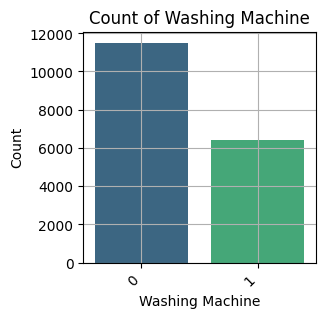

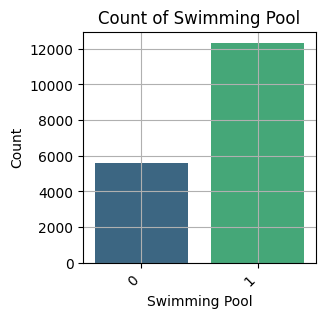

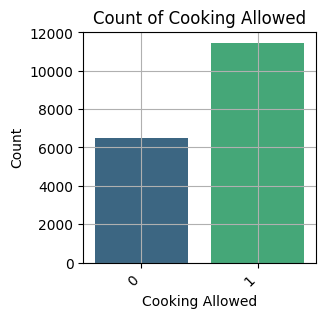

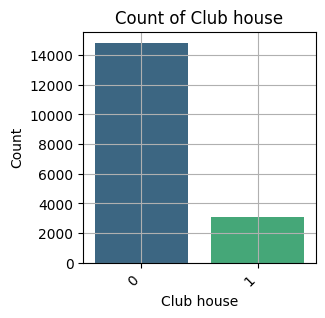

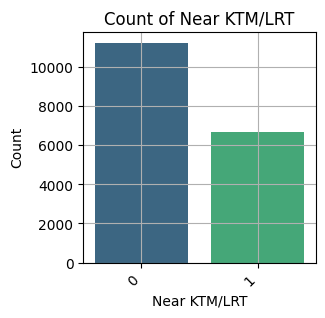

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data.csv')

# Define numerical and categorical columns
numerical_cols = ['monthly_rent', 'size']
categorical_cols = ['location_bin','rooms', 'parking', 'bathroom', 'property_type', 'furnished', 'region', 'Playground', 'Security',
                    'Barbeque area', 'Tennis Court', 'Minimart', 'Lift', 'Multipurpose hall',
                    'Gymnasium', 'Air-Cond', 'Jogging Track', 'Internet', 'Sauna', 'Squash Court',
                    'Washing Machine', 'Swimming Pool', 'Cooking Allowed', 'Club house', 'Near KTM/LRT']

# Univariate analysis for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Univariate analysis for categorical variables (smaller plots)
for col in categorical_cols:
    plt.figure(figsize=(3, 3))
    sns.countplot(data=df, x=col, hue=col, palette='viridis', legend=False)
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.show()


## Bivariate Analysis

## Scatterplots

##Boxplot

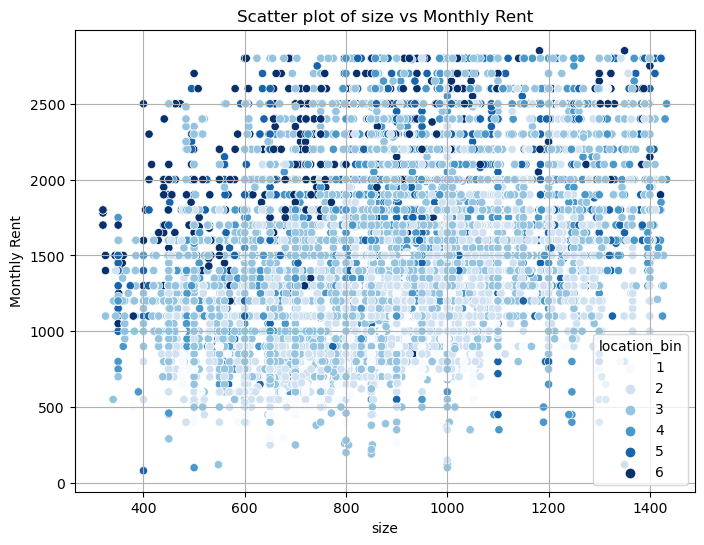

TypeError: Axes.boxplot() got an unexpected keyword argument 'legend'

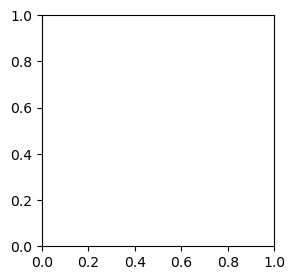

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data.csv')

# Define numerical and categorical columns
numerical_cols = ['size']
categorical_cols = ['location_bin','rooms', 'parking', 'bathroom', 'property_type', 'furnished', 'region', 'Playground', 'Security',
                    'Barbeque area', 'Tennis Court', 'Minimart', 'Lift', 'Multipurpose hall',
                    'Gymnasium', 'Air-Cond', 'Jogging Track', 'Internet', 'Sauna', 'Squash Court',
                    'Washing Machine', 'Swimming Pool', 'Cooking Allowed', 'Club house', 'Near KTM/LRT']

# Bivariate analysis for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='monthly_rent', hue='location_bin',palette='Blues')
    plt.title(f'Scatter plot of {col} vs Monthly Rent')
    plt.xlabel(col)
    plt.ylabel('Monthly Rent')
    plt.grid(True)
    plt.show()

# Bivariate analysis for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(3, 3))
    sns.boxplot(data=df, x=col, y='monthly_rent', hue=col, palette='viridis', legend=False)
    plt.title(f'Box plot of {col} vs. Monthly Rent')
    plt.xlabel(col)
    plt.ylabel('Monthly Rent')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.show()


## Multivariate Analysis

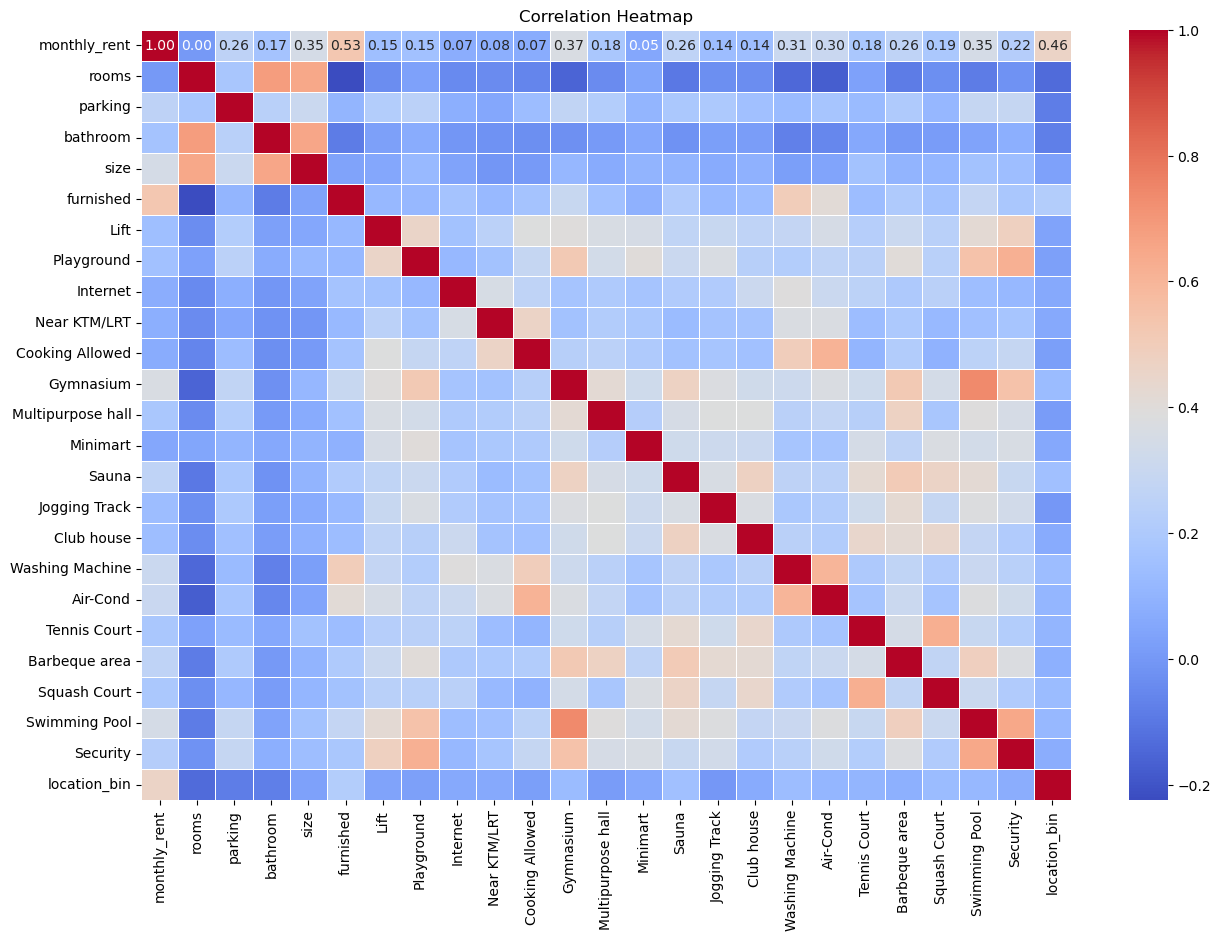

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv("data.csv")

# Step 2: Exclude the columns "location", "property_type", and "region"
columns_to_exclude = ["location", "property_type", "region"]
df_numeric = df.drop(columns_to_exclude, axis=1)

# Step 3: Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Step 4: Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


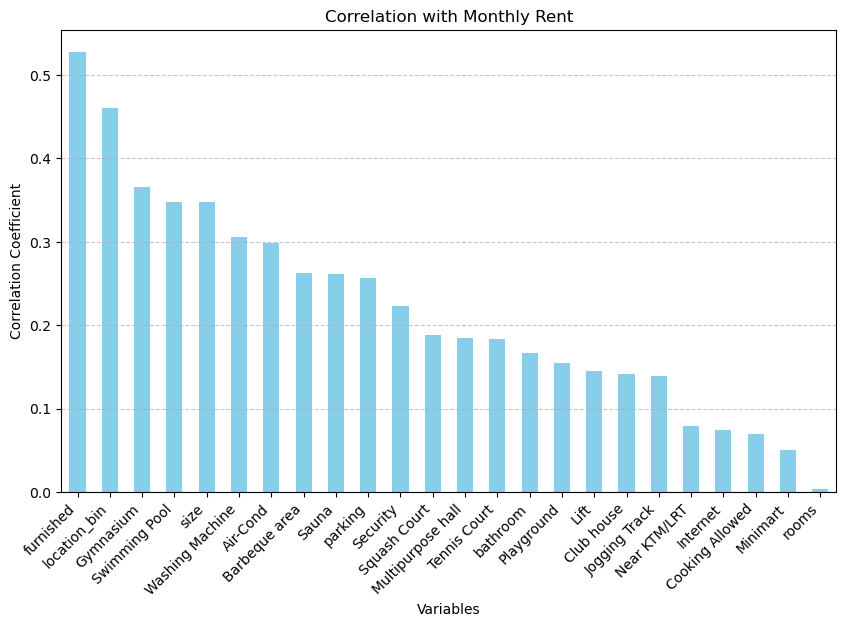

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("data.csv")

# Exclude non-numeric columns and target variable
numeric_data = data.drop(columns=["location", "property_type", "region","monthly_rent"])

# Calculate correlation coefficients with the target variable
correlation = numeric_data.corrwith(data["monthly_rent"])
sorted_correlation = correlation.sort_values(ascending=False)

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
sorted_correlation.plot(kind="bar", color="skyblue")
plt.title("Correlation with Monthly Rent")
plt.xlabel("Variables")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Prediction

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('data.csv')

# Check the data structure
print(data.head())

# Extract features and target variable
X = data.drop('monthly_rent', axis=1)
y = data['monthly_rent']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessor and fit on training data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Define a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[model_name] = {'MSE': mse, 'R2': r2}

    print(f"{model_name}: MSE = {mse:.4f}, R2 = {r2:.4f}")

# Compare the performance of the models
results_df = pd.DataFrame(results).T
print(results_df)


   monthly_rent    location      property_type  rooms  parking  bathroom  \
0        2300.0      Cheras        Condominium    3.0      1.0       2.0   
1        1000.0  Taman Desa          Apartment    3.0      0.0       2.0   
2        1700.0      Sentul          Apartment    2.0      1.0       2.0   
3        1299.0  Mont Kiara  Service Residence    1.0      1.0       1.0   
4        1500.0     Setapak          Apartment    3.0      1.0       2.0   

   size  furnished        region  Lift  ...  Jogging Track  Club house  \
0  1170          1  Kuala Lumpur     1  ...              1           0   
1   650          2  Kuala Lumpur     1  ...              1           0   
2   743          1  Kuala Lumpur     1  ...              0           0   
3   494          0  Kuala Lumpur     1  ...              1           1   
4   884          1  Kuala Lumpur     1  ...              0           0   

   Washing Machine  Air-Cond  Tennis Court  Barbeque area  Squash Court  \
0                0     

# Prediction with selected features (optional)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Load the dataset
data = pd.read_csv('data.csv')

# Check the data structure
print(data.head())

# Extract features and target variable
#X = data[['location_bin', 'property_type','furnished','size','region','Gymnasium', 'Swimming Pool']]
X = data.drop('monthly_rent', axis=1)
y = data['monthly_rent']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessor and fit on training data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Define a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Convert negative MSE scores to positive
    cv_scores = -cv_scores

    # Calculate the average MSE
    average_mse = cv_scores.mean()

    # Store the results
    results[model_name] = {'MSE': mse, 'R2': r2, "Average MSE": average_mse}

    print(f"{model_name}: MSE = {mse:.4f}, R2 = {r2:.4f}, Average MSE = {average_mse:.4f}")

# Compare the performance of the models
results_df = pd.DataFrame(results).T
print(results_df)


   monthly_rent    location      property_type  rooms  parking  bathroom  \
0        2300.0      Cheras        Condominium    3.0      1.0       2.0   
1        1000.0  Taman Desa          Apartment    3.0      0.0       2.0   
2        1700.0      Sentul          Apartment    2.0      1.0       2.0   
3        1299.0  Mont Kiara  Service Residence    1.0      1.0       1.0   
4        1500.0     Setapak          Apartment    3.0      1.0       2.0   

   size  furnished        region  Swimming Pool  ...  Washing Machine  \
0  1170          1  Kuala Lumpur              1  ...                0   
1   650          2  Kuala Lumpur              1  ...                0   
2   743          1  Kuala Lumpur              1  ...                1   
3   494          0  Kuala Lumpur              1  ...                0   
4   884          1  Kuala Lumpur              1  ...                0   

   Gymnasium  Tennis Court  Jogging Track  Security  Squash Court  Playground  \
0          1           

# Import Libraries for Machine Learning

In [19]:
#pip install xgboost 

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 330.3 kB/s eta 0:05:02
   ---------------------------------------- 0.1/99.8 MB 440.4 kB/s eta 0:03:47
   ---------------------------------------- 0.1/99.8 MB 787.7 kB/s eta 0:02:07
   ---------------------------------------- 0.2/99.8 MB 1.1 MB/s eta 0:01:30
   ---------------------------------------- 0.3/99.8 MB 1.4 MB/s eta 0:01:14
   ---------------------------------------- 0.5/99.8 MB 1.7 MB/s eta 0:00:59
   ---------------------------------------- 0.5/99.8 MB 1.5 MB/s eta 0:01:05
   ---------------------------------------- 0.7/99.8 MB 1.8 MB/s eta 0:00:55
   ---------------------------------------- 0.7/99.8 MB 1.8 MB/s eta 0:00:55
   ---------------------------------------- 0.8/99.8 MB 1.7 MB/s eta 0:00:58
   ---------------------------------------- 1.0/99.8 MB 1.8 MB/s eta 0:00:56
   ----

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Pre-processing



## Load Cleaned Dataset

In [21]:
# Load the dataset
data = pd.read_csv('data.csv')

In [22]:
data.head()

,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region,Lift,...,Jogging Track,Club house,Washing Machine,Air-Cond,Tennis Court,Barbeque area,Squash Court,Swimming Pool,Security,location_bin
0,2300.0,Cheras,Condominium,3.0,1.0,2.0,1170,1,Kuala Lumpur,1,...,1,0,0,1,0,1,0,1,1,3
1,1000.0,Taman Desa,Apartment,3.0,0.0,2.0,650,2,Kuala Lumpur,1,...,1,0,0,0,0,0,0,1,0,4
2,1700.0,Sentul,Apartment,2.0,1.0,2.0,743,1,Kuala Lumpur,1,...,0,0,1,0,0,0,1,1,1,4
3,1299.0,Mont Kiara,Service Residence,1.0,1.0,1.0,494,0,Kuala Lumpur,1,...,1,1,0,1,0,1,0,1,1,6
4,1500.0,Setapak,Apartment,3.0,1.0,2.0,884,1,Kuala Lumpur,1,...,0,0,0,0,0,0,0,1,1,4


## Feature Selection
Columns 'location_bin', 'property_type','furnished','size','region','Gymnasium', 'Swimming Pool', ‘location’, ‘region’, ‘rooms’, ‘property_type’ are selected while the rest are dropped.

In [23]:
# Drop Columns, feature selection according to correlation
columns_to_drop = ['Minimart','Cooking Allowed','Internet','Near KTM/LRT','Jogging Track',
                   'Club house','Lift','Playground','bathroom','Tennis Court','Multipurpose hall',
                   'Squash Court','Security','parking','Sauna','Barbeque area']
data.drop(columns=columns_to_drop, inplace=True)

In [24]:
data.head()

,monthly_rent,location,property_type,rooms,size,furnished,region,Gymnasium,Washing Machine,Air-Cond,Swimming Pool,location_bin
0,2300.0,Cheras,Condominium,3.0,1170,1,Kuala Lumpur,1,0,1,1,3
1,1000.0,Taman Desa,Apartment,3.0,650,2,Kuala Lumpur,0,0,0,1,4
2,1700.0,Sentul,Apartment,2.0,743,1,Kuala Lumpur,1,1,0,1,4
3,1299.0,Mont Kiara,Service Residence,1.0,494,0,Kuala Lumpur,1,0,1,1,6
4,1500.0,Setapak,Apartment,3.0,884,1,Kuala Lumpur,0,0,0,1,4


## Set Constants for Random Seed and Folds
For reproducible research, all random seeds used shall be set as 42. The number of folds are all set to 5.

In [25]:
random_seed = 42
folds = 5

## Encoding
Columns with categorical values needs to be encoded before training. OneHotEncoder is used.

In [26]:
# Extract features and target variable
X = data.drop('monthly_rent', axis=1)
y = data['monthly_rent']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


## Train-test Split
Before training, the data is split into training and testing sets, following a ratio of 0.8:0.2.

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessor and fit on training data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Model Training
5 models are selected. Linear Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.


In [28]:
# Define a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

## Training 5 Preliminary Models
The preliminary round of training is trained without cross validation and is used to gauge the effectiveness and suitability of each model with and without feature selection before testing the robustness of the results with k-fold cross validation.


In [29]:
# Train and evaluate each model
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[model_name] = {'MSE': mse, 'R2': r2}

# Compare the performance of the models
print(pd.DataFrame(results).T)

                            MSE        R2
Linear Regression  98166.429650  0.602327
Decision Tree      85599.403572  0.653236
Random Forest      60434.454911  0.755180
Gradient Boosting  89692.083527  0.636657
XGBoost            65705.232143  0.733828


## K-fold Cross Validation
For k-fold cross validation, the number of folds is set to the pre-declared "folds" variable.

In [30]:
# Train and evaluate models with k-fold cross-validation
kf = KFold(n_splits=folds, shuffle=True, random_state=random_seed)

results_cv = {}

for name, model in models.items():
    # With k-fold cross-validation, evaluate results
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Store the results
    results_cv[name] = {
        'MSE_CV': -mse_scores.mean(),
        'R2_CV': r2_scores.mean()
    }


# Compare the performance of the models
print(pd.DataFrame(results_cv).T)

                         MSE_CV     R2_CV
Linear Regression  96558.677563  0.616009
Decision Tree      94020.854117  0.629567
Random Forest      61564.483504  0.755406
Gradient Boosting  87947.336846  0.650264
XGBoost            66196.811345  0.736933


# Hyperparameter Tuning for Most Robust Models
After performing K-fold Cross-validation, Random Forest and XGBoost models are found to be the most robust. To increase the efficacy of the models, hyperparameter tunings are performed next.


## Hyperparameter Tuning for Random Forest
For hyperparameter tuning, mean-squared-error and R-squared are used as performance metrics. Three possible values are set for n_estimators, max_depth, min_samples_split, min_samples_leaf to test the hyperparameters while limiting processing time.


### Declare Hyperparameter Grid

In [31]:
# Define the hyperparameters grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

### Mean-squared-error (MSE) Tuning for Random Forest Model

In [32]:
# Define the Random Forest model
rf = RandomForestRegressor()

# MSE Hyperparameters
# Perform Grid Search with 5-fold cross-validation
grid_search_rf_mse = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=folds, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf_mse.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best MSE Hyperparameters:", grid_search_rf_mse.best_params_)

# Train the model with the best hyperparameters
best_rf_mse = grid_search_rf_mse.best_estimator_
best_rf_mse.fit(X_train, y_train)

# Evaluate the model
y_pred_rf_mse = best_rf_mse.predict(X_test)
mse_rf_mse = mean_squared_error(y_test, y_pred_rf_mse)
r2_rf_mse = r2_score(y_test, y_pred_rf_mse)

print("Best MSE Performance:")
print(f"  MSE (Test): {mse_rf_mse:.4f}")
print(f"  R2 (Test): {r2_rf_mse:.4f}")

Best MSE Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best MSE Performance:
  MSE (Test): 59907.2093
  R2 (Test): 0.7573


### R-squared (R2) Tuning for Random Forest Model

In [33]:
# R2 Hyperparameters
# Perform Grid Search with 5-fold cross-validation
grid_search_rf_r2 = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf_r2.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best R2 Hyperparameters:", grid_search_rf_r2.best_params_)

# Train the model with the best hyperparameters
best_rf_r2 = grid_search_rf_r2.best_estimator_
best_rf_r2.fit(X_train, y_train)

# Evaluate the model
y_pred_rf_r2 = best_rf_r2.predict(X_test)
mse_rf_r2 = mean_squared_error(y_test, y_pred_rf_r2)
r2_rf_r2 = r2_score(y_test, y_pred_rf_r2)

print("Best R2 Performance:")
print(f"  MSE (Test): {mse_rf_r2:.4f}")
print(f"  R2 (Test): {r2_rf_r2:.4f}")

Best R2 Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best R2 Performance:
  MSE (Test): 59764.8808
  R2 (Test): 0.7579


## Hyperparameter Tuning for XGBoost
For hyperparameter tuning, mean-squared-error and R-squared are used as performance metrics. Three possible values are set for n_estimators, max_depth, learning_rate, gamma, subsample, and colsample_bytree to test the hyperparameters while limiting processing time.


### Declare Hyperparameter Grid

In [34]:
# Define the hyperparameters grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

### Mean-squared-error (MSE) Tuning for XGBoost Model

In [104]:
# Define the XGBoost model
xgb = XGBRegressor()

# MSE Hyperparameters
# Perform Grid Search with 5-fold cross-validation for MSE
grid_search_xgb_mse = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=folds, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb_mse.fit(X_train, y_train)

# Get the best hyperparameters for MSE
best_params_xgb_mse = grid_search_xgb_mse.best_params_

# Print the best hyperparameters found
print("Best MSE Hyperparameters:", best_params_xgb_mse)

# Train the model with the best hyperparameters for MSE
best_xgb_mse = XGBRegressor(**best_params_xgb_mse)
best_xgb_mse.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb_mse = best_rf_mse.predict(X_test)
mse_xgb_mse = mean_squared_error(y_test, y_pred_xgb_mse)
r2_xgb_mse = r2_score(y_test, y_pred_xgb_mse)

print("Best MSE Performance:")
print(f"  MSE (Test): {mse_xgb_mse:.4f}")
print(f"  R2 (Test): {r2_xgb_mse:.4f}")

Best MSE Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best MSE Performance:
  MSE (Test): 59907.2093
  R2 (Test): 0.7573


### R-squared (R2) Tuning for XGBoost Model

In [36]:
# R2 Hyperparameters
# Perform Grid Search with 5-fold cross-validation for R2 score
grid_search_xgb_r2 = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_r2.fit(X_train, y_train)

# Get the best hyperparameters for R2 score
best_params_xgb_r2 = grid_search_xgb_r2.best_params_

# Print the best hyperparameters found
print("Best R2 Hyperparameters:", best_params_xgb_r2)

# Train the model with the best hyperparameters for R2 score
best_xgb_r2 = XGBRegressor(**best_params_xgb_r2)
best_xgb_r2.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb_r2 = best_rf_r2.predict(X_test)
mse_xgb_r2 = mean_squared_error(y_test, y_pred_xgb_r2)
r2_xgb_r2 = r2_score(y_test, y_pred_xgb_r2)

print("Best R2 Performance:")
print(f"  MSE (Test): {mse_xgb_r2:.4f}")
print(f"  R2 (Test): {r2_xgb_r2:.4f}")

Best R2 Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best R2 Performance:
  MSE (Test): 59764.8808
  R2 (Test): 0.7579


### Tabulate Hyperparameter Tuning Results

In [37]:
results = np.array([[mse_rf_mse, r2_rf_mse],
                 [mse_rf_r2, r2_rf_r2],
                 [mse_xgb_mse, r2_xgb_mse],
                 [mse_xgb_r2, r2_xgb_r2]])

df_results = pd.DataFrame(results, index=['Random Forest Best MSE', 'Random Forest Best R2', 'XGB Best MSE', 'XGB Best R2'],
                          columns=['MSE', 'R2'])
print(df_results)

                                 MSE        R2
Random Forest Best MSE  59907.209319  0.757316
Random Forest Best R2   59764.880795  0.757892
XGB Best MSE            59907.209319  0.757316
XGB Best R2             59764.880795  0.757892


### Final Models

In [38]:
# Define a dictionary of models
models_final = {
    'Tuned Random Forest': grid_search_rf_mse.best_estimator_,
    'Tuned XGBoost': XGBRegressor(**best_params_xgb_mse)
}

In [39]:
# Train and evaluate models with k-fold cross-validation
kf = KFold(n_splits=folds, shuffle=True, random_state=random_seed)

results_final = {}

for name, model in models_final.items():
    # With k-fold cross-validation, evaluate results
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    
    # Store the results
    results_final[name] = {
        'MSE_FINAL': -mse_scores.mean(),
        'R2_FINAL': r2_scores.mean()
    }


# Compare the performance of the models
print(pd.DataFrame(results_final).T)

                        MSE_FINAL  R2_FINAL
Tuned Random Forest  60788.812557  0.758495
Tuned XGBoost        59314.525177  0.764258


### Save the Trained Model
##### After training your XGBoost model, save it using joblib

In [40]:
#pip install joblib

In [61]:
import pandas as pd
import joblib

# Assuming best_xgb_r2 is your 
# Save an trained model best_xgb_r2
joblib.dump(best_xgb_r2, 'rentalPredictXgb.joblib')


# Assuming clean_df is your DataFrame
mean_rent_by_location = clean_df.groupby('location')['monthly_rent'].mean()
bin_edges = pd.qcut(mean_rent_by_location, q=6, labels=False, duplicates='drop', retbins=True)[1]

# Save bin edges and mean rent by location
joblib.dump((bin_edges, mean_rent_by_location.to_dict()), 'bin_edges_and_mean_rent.pkl')


['bin_edges_and_mean_rent.pkl']